In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# import zipfile
# file = zipfile.ZipFile('/content/household_power_consumption.zip', 'r')
# file.extractall('data')
power_data = pd.read_csv('/content/data/household_power_consumption.txt', sep = ';', header=0,
                 low_memory=False, infer_datetime_format=True,
                 parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [3]:
power_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
power_data.replace('?', 'nan', inplace=True) 
power_data = power_data.astype('float32')

In [5]:
power_data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
power_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091631e+00,1.237042e-01,2.433813e+02,4.629239e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057005e+00,1.128308e-01,4.114049e+00,4.440444e+00,6.104221e+00,5.758089e+00,8.458705e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [7]:
power_data = power_data.fillna(power_data.mean())

power_data_daily = power_data.resample('D').sum()
power_data_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


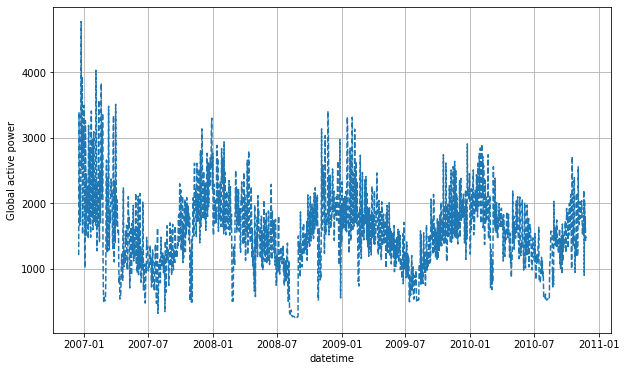

In [8]:
plt.figure(figsize=(10,6))
plt.plot(power_data_daily.index, power_data_daily.Global_active_power, '--')
plt.grid()
plt.xlabel('datetime')
plt.ylabel('Global active power')
plt.show()

In [9]:
import scipy
import scipy.stats
from scipy.stats import pearsonr

corr2,_ = pearsonr(power_data_daily.Voltage,power_data_daily.Global_intensity)
corr2

0.05221350712869458

In [10]:
train_data = power_data_daily.iloc[:1077,:]
test_data = power_data_daily.iloc[1077:,:]

train_data.reset_index(inplace=True)
train_data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [11]:
power_data_train = train_data.iloc[:,:2]
power_data_train = power_data_train.rename(columns={"datetime": "ds", "Global_active_power": "y"})

power_data_train.head()

,ds,y
0,2006-12-16,1209.176025
1,2006-12-17,3390.459961
2,2006-12-18,2203.825928
3,2006-12-19,1666.193970
4,2006-12-20,2225.748047


In [12]:
test_data.reset_index(inplace = True)
test_data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2009-11-27,1380.026001,133.052002,348276.68750,5704.000000,0.0,396.0,11599.0
1,2009-11-28,1858.949951,225.218002,347898.87500,7784.799805,3199.0,386.0,14350.0
2,2009-11-29,1650.962036,191.056000,350364.56250,6878.399902,1073.0,3061.0,7828.0
3,2009-11-30,1745.189941,153.382004,351020.59375,7232.200195,1080.0,361.0,12039.0
4,2009-12-01,1756.378052,141.873993,349391.75000,7312.799805,0.0,354.0,10821.0


In [13]:
power_data_test = test_data.iloc[:,:2]
power_data_test = power_data_test.rename(columns={"datetime": "ds", "Global_active_power": "y"})

power_data_test.head()

,ds,y
0,2009-11-27,1380.026001
1,2009-11-28,1858.949951
2,2009-11-29,1650.962036
3,2009-11-30,1745.189941
4,2009-12-01,1756.378052


In [14]:
from fbprophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(power_data_train)

forecast = model.predict(power_data_test) 
forecast.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1227.555640,1525.508146,2645.730352,1227.555640,1227.555640,870.932530,870.932530,870.932530,352.525456,352.525456,352.525456,-64.148022,-64.148022,-64.148022,582.555096,582.555096,582.555096,0.0,0.0,0.0,2098.488170
1,2009-11-28,1227.677685,1838.838351,2951.679057,1227.677685,1227.677685,1174.164111,1174.164111,1174.164111,352.525456,352.525456,352.525456,245.863951,245.863951,245.863951,575.774703,575.774703,575.774703,0.0,0.0,0.0,2401.841796
2,2009-11-29,1227.799730,1801.542553,2942.782066,1227.799730,1227.799730,1148.111460,1148.111460,1148.111460,352.525456,352.525456,352.525456,228.564840,228.564840,228.564840,567.021163,567.021163,567.021163,0.0,0.0,0.0,2375.911190
3,2009-11-30,1227.921775,1430.394478,2530.522450,1227.921775,1227.921775,748.013775,748.013775,748.013775,352.525456,352.525456,352.525456,-161.313317,-161.313317,-161.313317,556.801636,556.801636,556.801636,0.0,0.0,0.0,1975.935551
4,2009-12-01,1228.043820,1472.317478,2612.664234,1228.043820,1228.043820,868.831712,868.831712,868.831712,352.525456,352.525456,352.525456,-29.337064,-29.337064,-29.337064,545.643320,545.643320,545.643320,0.0,0.0,0.0,2096.875533


In [15]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2009-11-27,2098.488170,1525.508146,2645.730352,1227.555640,1227.555640,1227.555640
1,2009-11-28,2401.841796,1838.838351,2951.679057,1227.677685,1227.677685,1227.677685
2,2009-11-29,2375.911190,1801.542553,2942.782066,1227.799730,1227.799730,1227.799730
3,2009-11-30,1975.935551,1430.394478,2530.522450,1227.921775,1227.921775,1227.921775
4,2009-12-01,2096.875533,1472.317478,2612.664234,1228.043820,1228.043820,1228.043820


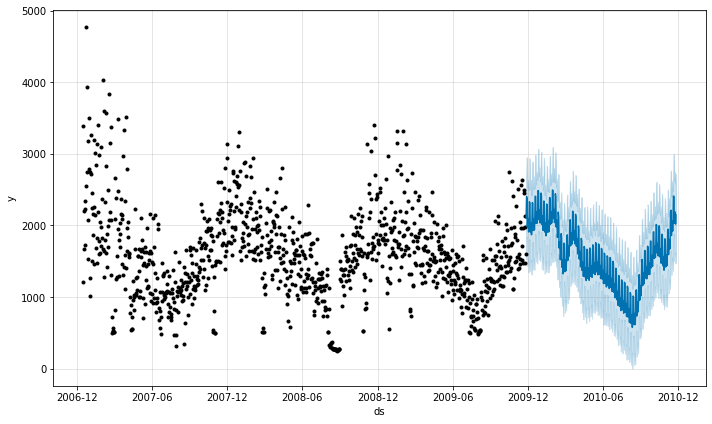

In [16]:
model.plot(forecast)
plt.show()

In [17]:
from sklearn import metrics

def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

MAPE = Metric(power_data_test['y'],forecast['yhat'])
round(MAPE,2)

20.81

In [18]:
RMSE = np.sqrt(metrics.mean_squared_error(power_data_test['y'],forecast['yhat']))
round(RMSE,4)

374.6036

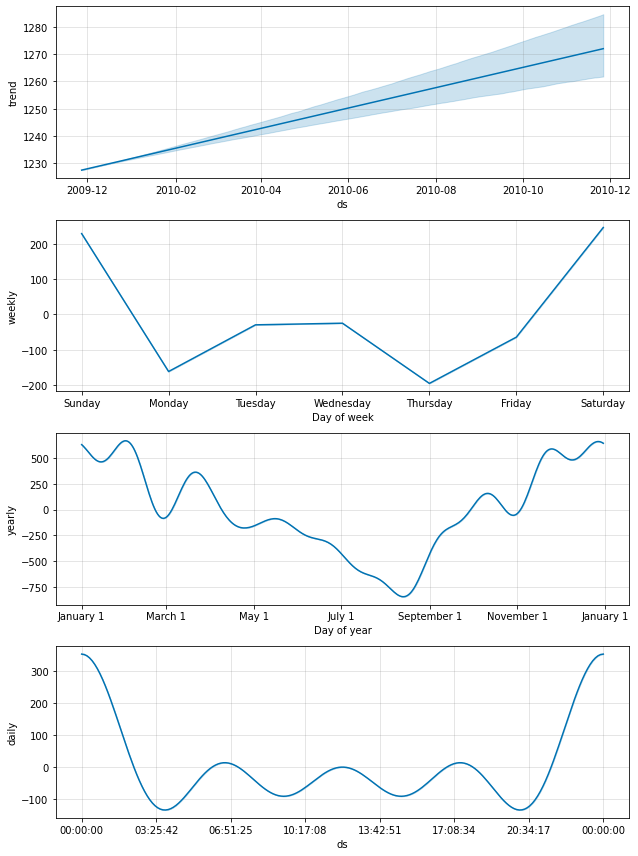

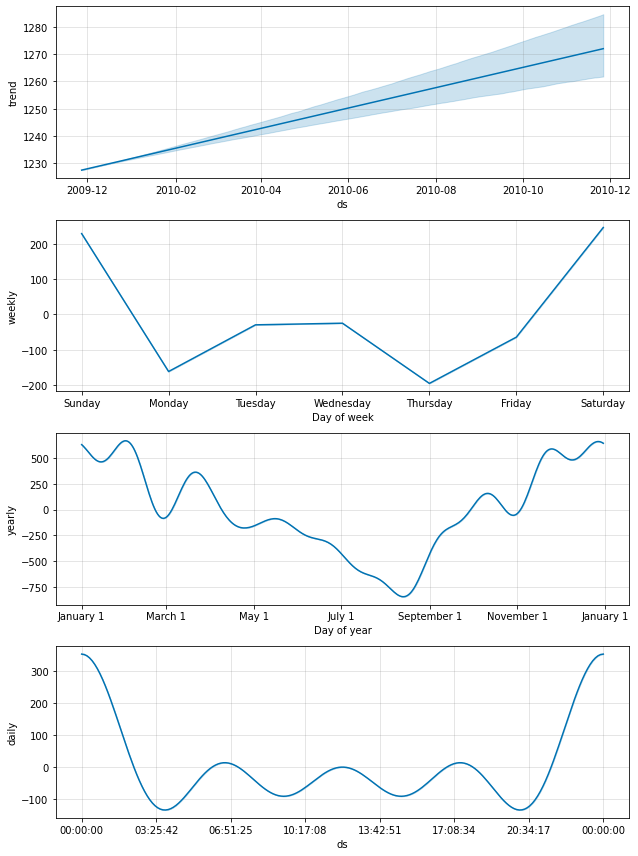

In [19]:
model.plot_components(forecast)

In [20]:
power_data_daily.reset_index(inplace=True)
power_data_daily.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [21]:
new_power_daily = power_data_daily.rename(columns = {'datetime':'ds','Global_active_power':'y',
                                           'Global_reactive_power':'add1','Voltage':'add2',
                                           'Global_intensity':'add3','Sub_metering_1':'add4',
                                          'Sub_metering_2':'add5','Sub_metering_3':'add6'})
new_power_daily.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [22]:
new_train = new_power_daily.iloc[:1077,:]
new_test = new_power_daily.iloc[1077:,:]

In [23]:
model = Prophet(daily_seasonality=True)
model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')
model.add_regressor('add4')
model.add_regressor('add5')
model.add_regressor('add6')

model = model.fit(new_train)
new_forecast = model.predict(new_test)
new_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,add2_lower,add2_upper,add3,add3_lower,add3_upper,add4,add4_lower,add4_upper,add5,add5_lower,add5_upper,add6,add6_lower,add6_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1310.545634,1366.358923,1397.136463,1310.545634,1310.545634,7.518641,7.518641,7.518641,0.611811,0.611811,0.611811,-232.332569,-232.332569,-232.332569,2.212554,2.212554,2.212554,0.821183,0.821183,0.821183,3.847123,3.847123,3.847123,70.432793,70.432793,70.432793,284.757745,284.757745,284.757745,-217.321258,-217.321258,-217.321258,-0.103529,-0.103529,-0.103529,3.099835,3.099835,3.099835,0.0,0.0,0.0,1380.978427
1,2009-11-28,1310.665825,1846.408260,1878.570534,1310.665825,1310.665825,-8.859759,-8.859759,-8.859759,0.502363,0.502363,0.502363,263.404254,263.404254,263.404254,-2.037390,-2.037390,-2.037390,0.826436,0.826436,0.826436,7.716037,7.716037,7.716037,551.138604,551.138604,551.138604,284.757745,284.757745,284.757745,261.551942,261.551942,261.551942,1.400178,1.400178,1.400178,3.428739,3.428739,3.428739,0.0,0.0,0.0,1861.804429
2,2009-11-29,1310.786015,1628.646876,1659.854577,1310.786015,1310.786015,-2.788985,-2.788985,-2.788985,1.216642,1.216642,1.216642,47.460461,47.460461,47.460461,0.787049,0.787049,0.787049,-0.578626,-0.578626,-0.578626,-1.456286,-1.456286,-1.456286,333.335649,333.335649,333.335649,284.757745,284.757745,284.757745,44.640255,44.640255,44.640255,0.144315,0.144315,0.144315,3.793334,3.793334,3.793334,0.0,0.0,0.0,1644.121664
3,2009-11-30,1310.906205,1725.942049,1758.622995,1310.906205,1310.906205,3.905889,3.905889,3.905889,1.406686,1.406686,1.406686,131.751041,131.751041,131.751041,0.777749,0.777749,0.777749,0.839567,0.839567,0.839567,4.465924,4.465924,4.465924,431.766358,431.766358,431.766358,284.757745,284.757745,284.757745,143.146856,143.146856,143.146856,-0.336567,-0.336567,-0.336567,4.198325,4.198325,4.198325,0.0,0.0,0.0,1742.672564
4,2009-12-01,1311.026396,1745.721688,1777.595947,1311.026396,1311.026396,5.950925,5.950925,5.950925,0.934830,0.934830,0.934830,150.953373,150.953373,150.953373,2.212554,2.212554,2.212554,0.843244,0.843244,0.843244,2.752970,2.752970,2.752970,451.391337,451.391337,451.391337,284.757745,284.757745,284.757745,163.647896,163.647896,163.647896,-1.661897,-1.661897,-1.661897,4.647592,4.647592,4.647592,0.0,0.0,0.0,1762.417732


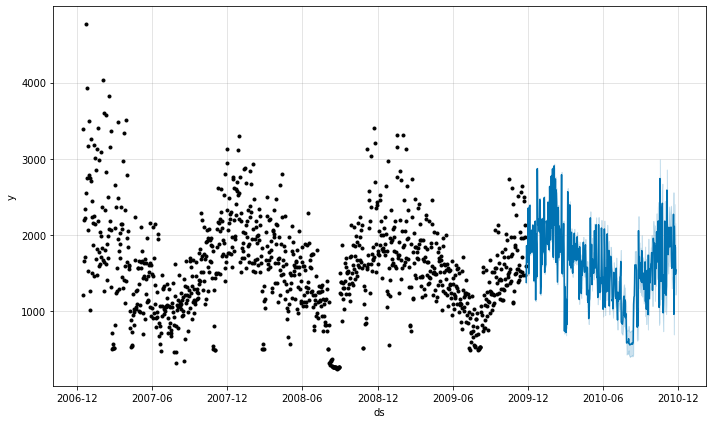

In [24]:
model.plot(new_forecast)
plt.show()

In [25]:
def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

MAPE = Metric(new_test['y'],new_forecast['yhat'])
round(MAPE,2)

2.61

In [26]:
RMSE = np.sqrt(metrics.mean_squared_error(new_test['y'],new_forecast['yhat']))
round(RMSE,4)

38.9406

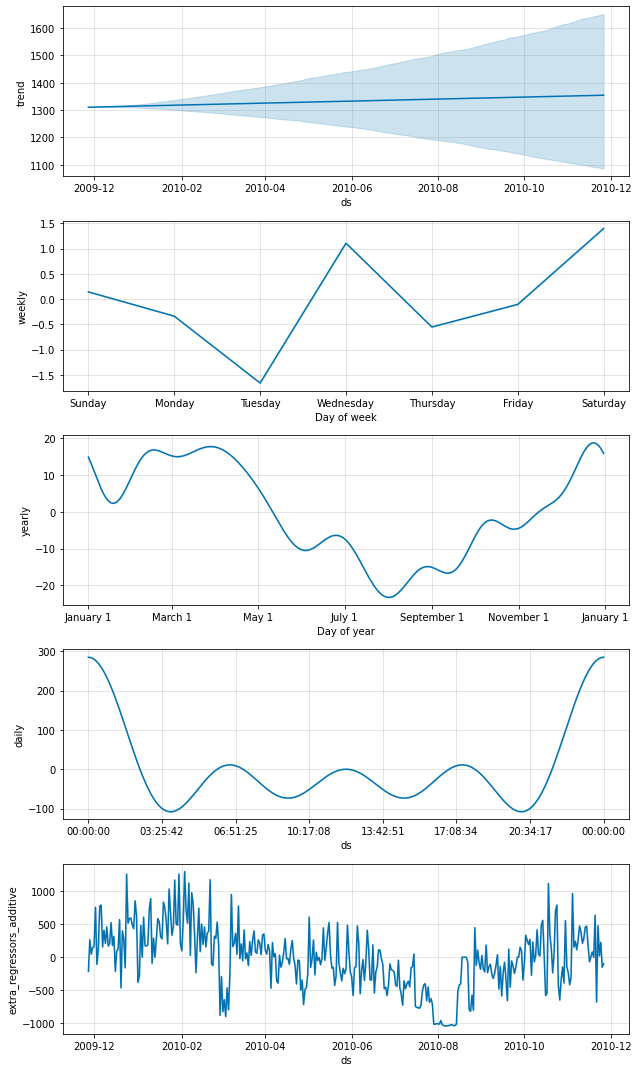

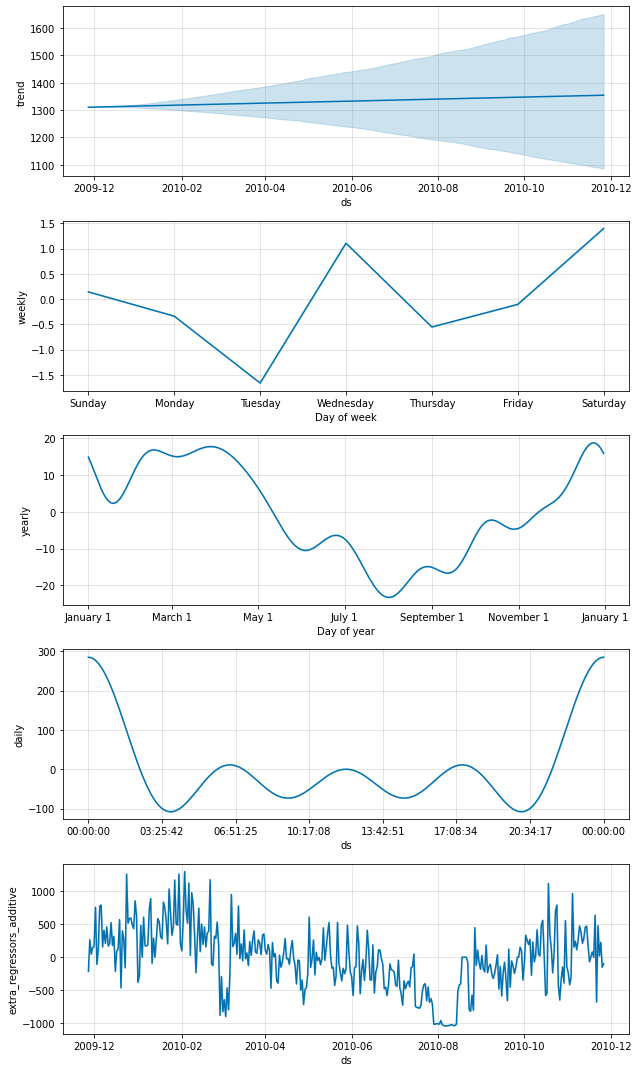

In [27]:
model.plot_components(new_forecast)